# **COVID-19 DISEASE TREND**
**Dhwanil Ranpura & Peter Martinez**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

df = pd.read_csv("/content/drive/MyDrive/CS 22B/owid-covid-data.csv")

In [19]:
# Clean the raw dataset using a function
def clean_data(df):

    # Define columns to keep
    columns_to_keep = [
        'date', 'location', 'continent',
        'new_cases', 'new_deaths', 'total_cases', 'total_deaths',
        'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
        'population', 'population_density',
        'stringency_index', 'reproduction_rate',
        'icu_patients', 'hosp_patients', 'positive_rate'
    ]

    # Define non-country regions to remove
    regions_to_remove = [
        "World", "Asia", "Europe", "Upper-middle-income countries",
        "European Union (27)", "North America", "Lower-middle-income countries",
        "South America", "Africa", "Oceania", "High-income countries", "Low-income countries"
    ]

    # Filter using functional style
    df = df[~df['location'].isin(regions_to_remove)][columns_to_keep]
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    return df

# Clean and save the dataset
df_cleaned = clean_data(df)
df_cleaned.to_csv('/content/drive/MyDrive/CS 22B/cleaned-covid-data.csv', index=False)
print("✅ Cleaned dataset saved.")


✅ Cleaned dataset saved.


In [20]:
# Loading the cleaned dataset
covid = pd.read_csv("/content/drive/MyDrive/CS 22B/cleaned-covid-data.csv")
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402910 entries, 0 to 402909
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     402910 non-null  object 
 1   location                 402910 non-null  object 
 2   continent                402910 non-null  object 
 3   new_cases                390071 non-null  float64
 4   new_deaths               390520 non-null  float64
 5   total_cases              391716 non-null  float64
 6   total_deaths             391716 non-null  float64
 7   people_vaccinated        65865 non-null   float64
 8   people_fully_vaccinated  62980 non-null   float64
 9   new_vaccinations         55747 non-null   float64
 10  population               402910 non-null  int64  
 11  population_density       358808 non-null  float64
 12  stringency_index         196190 non-null  float64
 13  reproduction_rate        183741 non-null  float64
 14  icu_

In [21]:
class CovidTrendAnalyzer:
    def __init__(self, covid, exclude_regions=None):
        # Initializes the analyzer with the given COVID DataFrame and regions to exclude.
        self.original_df = covid.copy()
        self.df = covid.copy()
        self.exclude_regions = exclude_regions or ["High-income countries"]
        self.top_countries = []
        self.top_df = None

    def preprocess(self):
        # Removes excluded regions and ensures the 'date' column is in datetime format.
        self.df = self.df[~self.df['location'].isin(self.exclude_regions)]
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
        self.df = self.df.dropna(subset=['date'])

    def get_top_countries(self, metric='total_cases', top_n=5, min_population=1_000_000):
        # Returns the top N countries based on the latest value of the given metric.
        latest = (
            self.df.sort_values('date')
            .groupby('location')[metric]
            .last()
            .nlargest(top_n)
        )
        self.top_countries = latest.index.tolist()
        return self.top_countries

    def prepare_top_dataframe(self, min_population=1_000_000):
        # Prepares a DataFrame for the top countries with 7-day average cases per 100k population.
        covid = self.df[self.df['location'].isin(self.top_countries)].copy()
        covid = covid[covid['population'] > min_population]

        covid['new_cases_7d_avg'] = covid.groupby('location')['new_cases'].transform(
            lambda x: x.rolling(7, min_periods=1).mean()
        )

        covid['cases_per_100k'] = (covid['new_cases_7d_avg'] / covid['population']) * 100_000
        covid['cases_per_100k'] = covid['cases_per_100k'].clip(upper=2000)

        covid = covid.dropna(subset=['cases_per_100k', 'new_cases_7d_avg', 'population'])
        covid = covid[covid['population'] > 0]
        covid = covid[covid['date'] >= '2020-03-03']

        self.top_df = covid
        return covid

    def get_country_df(self, country):
        # Returns a cleaned DataFrame for a specific country with 7-day average of new cases.
        covid = self.df[self.df['location'] == country].copy()
        covid['date'] = pd.to_datetime(covid['date'], errors='coerce')
        covid = covid.dropna(subset=['date'])
        covid['new_cases_7d_avg'] = covid['new_cases'].rolling(window=7, center=True).mean()
        return covid

    def get_latest_totals(self, metrics=['total_cases', 'total_deaths']):
        # Returns the most recent non-zero values of specified metrics for each country.
        covid = self.df.dropna(subset=metrics)
        for metric in metrics:
            covid = covid[covid[metric] > 0]
        covid = covid.sort_values('date').groupby('location').tail(1)
        return covid

    def get_vaccination_case_death_df(self):
        # Returns a DataFrame linking vaccination rates with new case and death rates per thousand.
        covid = self.df.copy()
        covid = covid.dropna(subset=[
            'people_fully_vaccinated', 'new_cases', 'new_deaths', 'population'
        ])
        covid = covid[covid['population'] > 1_000_000]

        covid['people_fully_vaccinated_per_hundred'] = (covid['people_fully_vaccinated'] / covid['population']) * 100
        covid['new_cases_per_thousand'] = (covid['new_cases'] / covid['population']) * 1_000
        covid['new_deaths_per_thousand'] = (covid['new_deaths'] / covid['population']) * 1_000

        covid['new_cases_per_thousand'] = covid.groupby('location')['new_cases_per_thousand'].transform(
            lambda x: x.rolling(7, min_periods=1).mean()
        )
        covid['new_deaths_per_thousand'] = covid.groupby('location')['new_deaths_per_thousand'].transform(
            lambda x: x.rolling(7, min_periods=1).mean()
        )

        covid = covid.dropna(subset=[
            'people_fully_vaccinated_per_hundred',
            'new_cases_per_thousand',
            'new_deaths_per_thousand'
        ])
        return covid

    def get_continent_totals(self):
        # Aggregates total new cases and deaths by continent.
        covid = self.df.dropna(subset=['new_cases', 'new_deaths', 'continent']).copy()
        covid = covid[covid['population'] > 0]

        region_summary = covid.groupby('continent').agg({
            'new_cases': 'sum',
            'new_deaths': 'sum'
        }).reset_index()

        region_summary.rename(columns={
            'new_cases': 'total_cases',
            'new_deaths': 'total_deaths'
        }, inplace=True)

        return region_summary

    def get_top5_deaths_per_100k_df(self):
        # Returns death rate per 100k population for top 5 countries with highest total deaths.
        self.get_top_countries(metric='total_deaths', top_n=5)
        self.prepare_top_dataframe()

        covid = self.top_df.copy()
        covid['new_deaths_7d_avg'] = covid.groupby('location')['new_deaths'].transform(
            lambda x: x.rolling(7, min_periods=1).mean()
        )
        covid['deaths_per_100k'] = (covid['new_deaths_7d_avg'] / covid['population']) * 100_000
        return covid[['date', 'location', 'deaths_per_100k']]

    def get_days_to_peak_by_continent(self):
        # Calculates days from first case to peak case per country and returns top country by peak in each continent.
        df = self.df.dropna(subset=['location', 'continent', 'date', 'new_cases']).copy()
        df = df[df['new_cases'] > 0]
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

        first_case_dates = df.groupby('location')['date'].min().rename('first_case_date')

        peak_rows = df.loc[df.groupby('location')['new_cases'].idxmax()][
            ['location', 'continent', 'date', 'new_cases']
        ].rename(columns={'date': 'peak_date', 'new_cases': 'peak_cases'})

        peak_data = peak_rows.merge(first_case_dates, on='location')
        peak_data['days_to_peak'] = (peak_data['peak_date'] - peak_data['first_case_date']).dt.days

        highest_peaks = (
            peak_data
            .sort_values('peak_cases', ascending=False)
            .groupby('continent')
            .first()
            .reset_index()
        )

        return highest_peaks[['continent', 'location', 'days_to_peak']]

**COVID-19 Trends Across Top 5 Countries (7-Day Avg New Cases per 100k)**

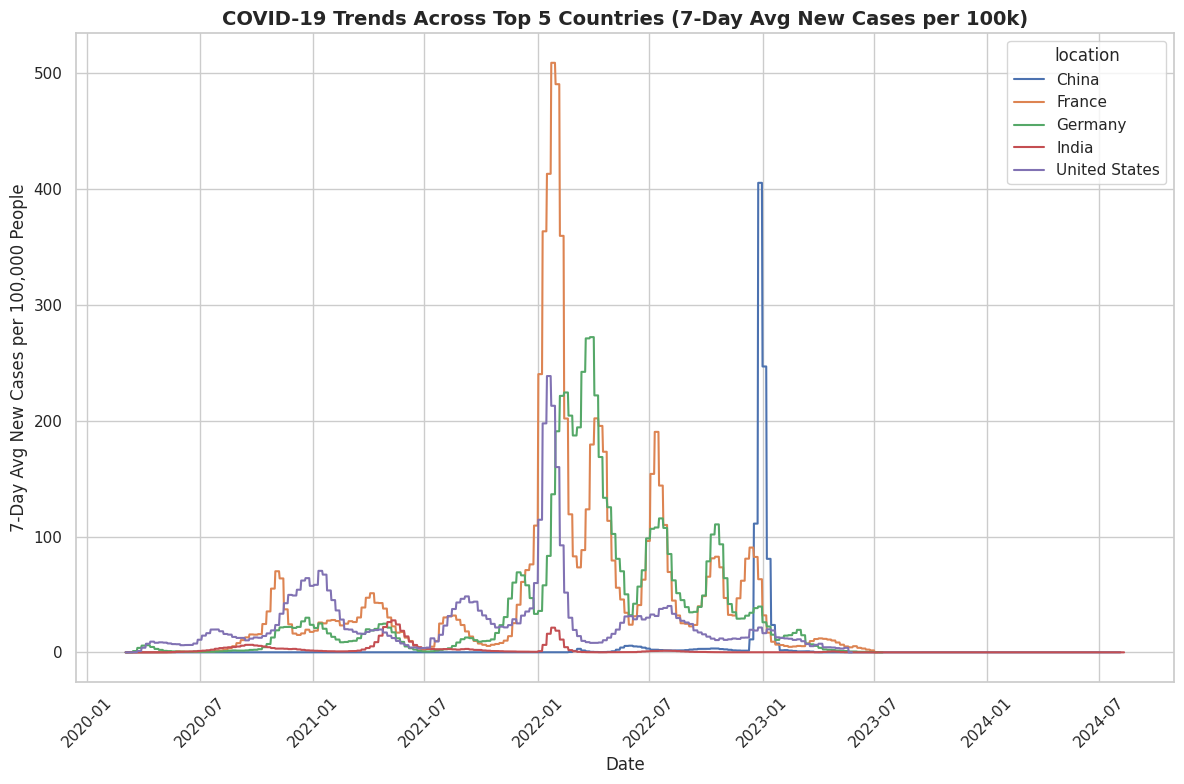

In [22]:
analyzer = CovidTrendAnalyzer(df_cleaned)
analyzer.preprocess()
analyzer.get_top_countries()
top_df = analyzer.prepare_top_dataframe()

# plotting the graph
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_df, x='date', y='cases_per_100k', hue='location', linewidth=1.5)

plt.title("COVID-19 Trends Across Top 5 Countries (7-Day Avg New Cases per 100k)", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("7-Day Avg New Cases per 100,000 People")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**7-Day Avg COVID-19 Deaths per 100K (Top 5 Countries by Total Deaths)**

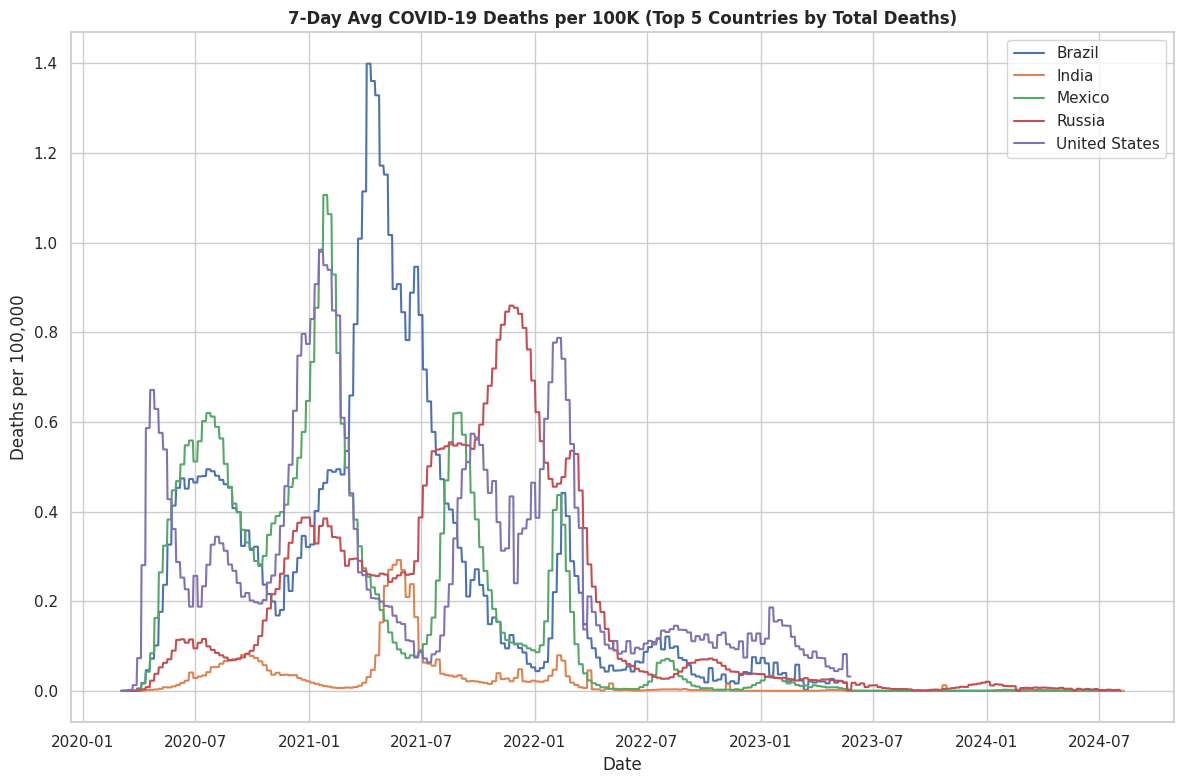

In [23]:
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()

deaths_df = analyzer.get_top5_deaths_per_100k_df()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for country in deaths_df['location'].unique():
    country_data = deaths_df[deaths_df['location'] == country]
    plt.plot(country_data['date'], country_data['deaths_per_100k'], label=country)

plt.title("7-Day Avg COVID-19 Deaths per 100K (Top 5 Countries by Total Deaths)", fontweight = 'bold')
plt.xlabel("Date")
plt.ylabel("Deaths per 100,000")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**COVID-19 Cases vs Lockdown Stringency in the United States**

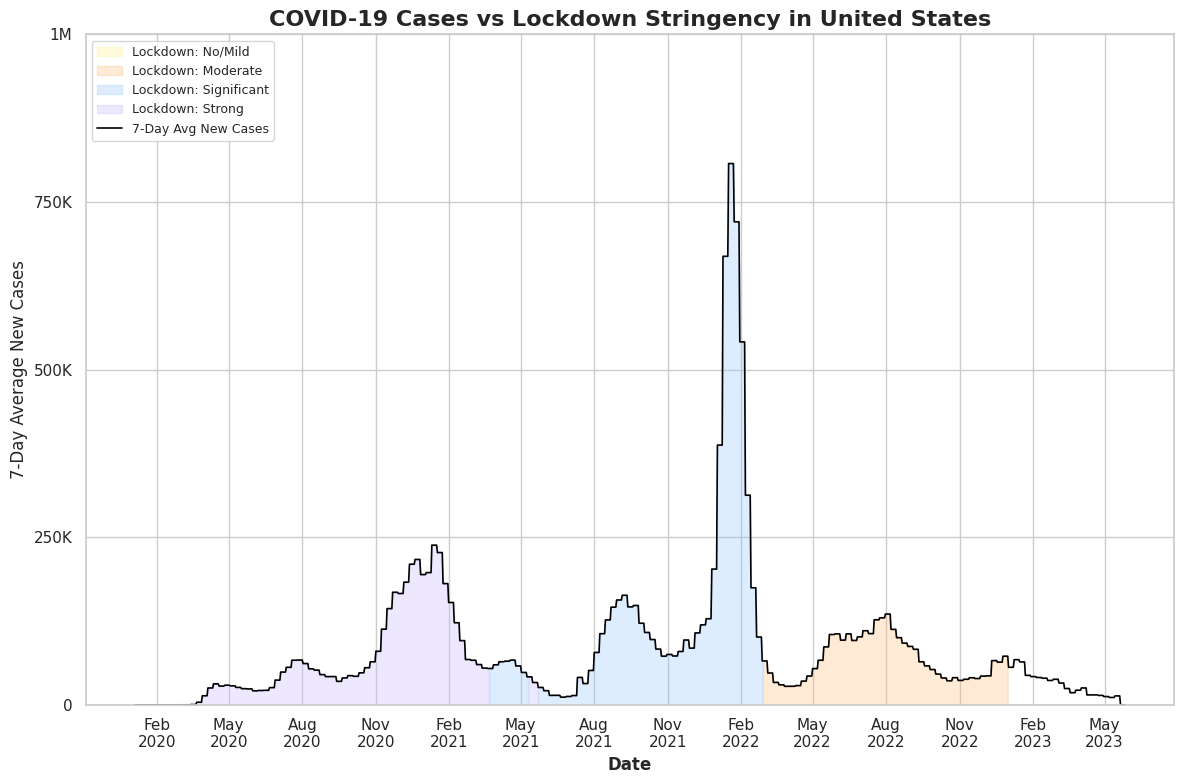

In [24]:
# Setup
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()

# Get specific country's processed data
country = "United States"
country_df = analyzer.get_country_df(country)

# Ensure 7-day rolling average cases are computed
country_df['new_cases_7d_avg'] = country_df['new_cases'].rolling(window=7, min_periods=1).mean()

# Define lockdown tiers
tier_thresholds = {
    "No/Mild": (0, 20),
    "Moderate": (20, 40),
    "Significant": (40, 60),
    "Strong": (60, 80),
    "Full Lockdown": (80, 100)
}
tier_labels = list(tier_thresholds.keys())
tier_bins = [0] + [v[1] for v in tier_thresholds.values()]
country_df['stringency_tier'] = pd.cut(
    country_df['stringency_index'],
    bins=tier_bins,
    labels=tier_labels,
    include_lowest=True
)

# Define tier colors
tier_colors = {
    "No/Mild": "#fef08a",
    "Moderate": "#fdba74",
    "Significant": "#93c5fd",
    "Strong": "#c4b5fd",
    "Full Lockdown": "#fca5a5"
}

# Utility: split tier data into continuous time segments
def get_continuous_segments(df):
    df = df.sort_values('date')
    segments = []
    current = []

    for i, row in df.iterrows():
        if not current:
            current.append(row)
        else:
            prev_date = current[-1]['date']
            if (row['date'] - prev_date).days <= 1:
                current.append(row)
            else:
                segments.append(pd.DataFrame(current))
                current = [row]

    if current:
        segments.append(pd.DataFrame(current))
    return segments

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

used_labels = set()  # Track added labels

for tier, color in tier_colors.items():
    mask = country_df['stringency_tier'] == tier
    tier_df = country_df[mask]
    segments = get_continuous_segments(tier_df)

    for seg in segments:
        label = f"Lockdown: {tier}" if f"Lockdown: {tier}" not in used_labels else None
        ax.fill_between(
            seg['date'],
            seg['new_cases_7d_avg'],
            color=color,
            alpha=0.3,
            label=label
        )
        used_labels.add(f"Lockdown: {tier}")

# Line plot for 7-day avg cases
sns.lineplot(data=country_df, x='date', y='new_cases_7d_avg', color='black', linewidth=1.2, label='7-Day Avg New Cases')

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Y-axis formatting
ax.set_ylabel("7-Day Average New Cases")
ax.set_ylim(0, 1_000_000)
ax.set_yticks([0, 250_000, 500_000, 750_000, 1_000_000])
ax.set_yticklabels(['0', '250K', '500K', '750K', '1M'])

# Title and legend
ax.set_title(f"COVID-19 Cases vs Lockdown Stringency in {country}", fontsize=16, weight='bold')
ax.set_xlabel("Date", weight='bold')
ax.legend(loc='upper left', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

**COVID-19 Deaths vs Lockdown Stringency in United States**

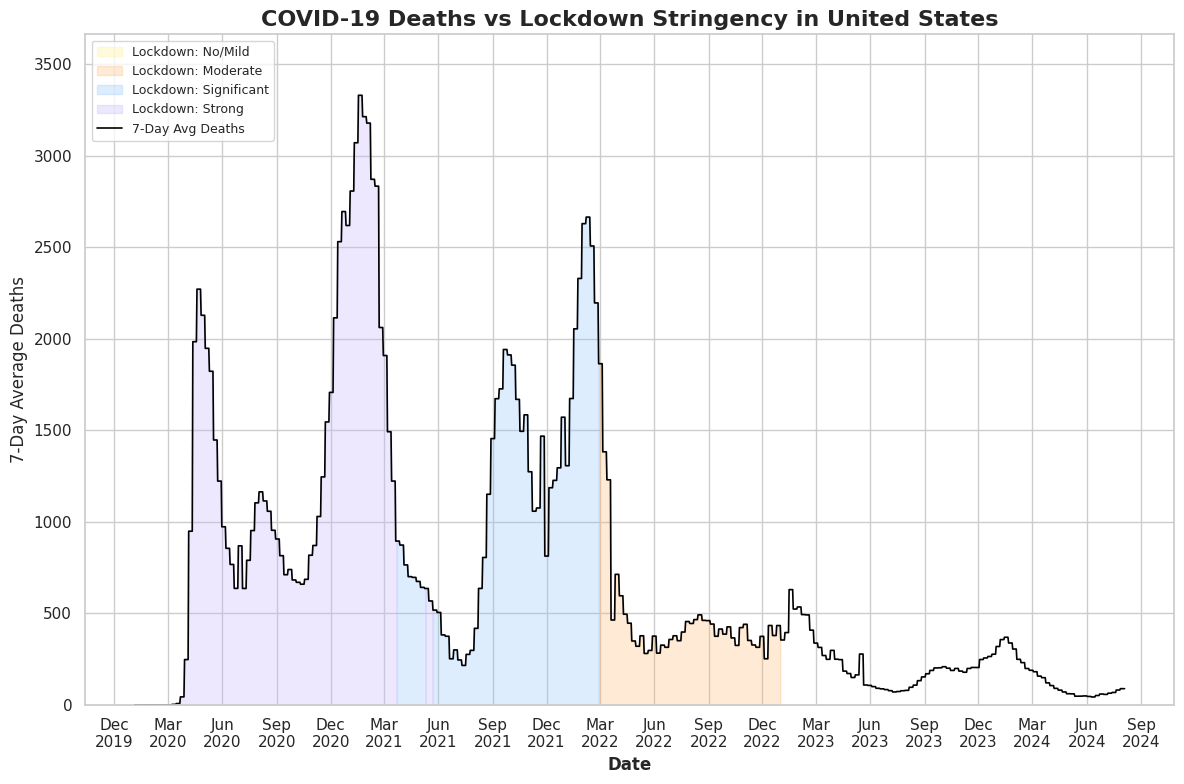

In [25]:
# Setup
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()

# Get specific country's processed data
country = "United States"
country_df = analyzer.get_country_df(country)

# Compute 7-day average deaths
country_df['new_deaths_7d_avg'] = country_df['new_deaths'].rolling(window=7, min_periods=1).mean()

# Define lockdown tiers
tier_thresholds = {
    "No/Mild": (0, 20),
    "Moderate": (20, 40),
    "Significant": (40, 60),
    "Strong": (60, 80),
    "Full Lockdown": (80, 100)
}
tier_labels = list(tier_thresholds.keys())
tier_bins = [0] + [v[1] for v in tier_thresholds.values()]
country_df['stringency_tier'] = pd.cut(
    country_df['stringency_index'],
    bins=tier_bins,
    labels=tier_labels,
    include_lowest=True
)

# Define tier colors
tier_colors = {
    "No/Mild": "#fef08a",
    "Moderate": "#fdba74",
    "Significant": "#93c5fd",
    "Strong": "#c4b5fd",
    "Full Lockdown": "#fca5a5"
}

# Utility: function to split data into continuous segments based on dates
def get_continuous_segments(df):
    df = df.sort_values('date')
    segments = []
    current = []

    for i, row in df.iterrows():
        if not current:
            current.append(row)
        else:
            prev_date = current[-1]['date']
            # If difference of one or fewer days, consider it continuous
            if (row['date'] - prev_date).days <= 1:
                current.append(row)
            else:
                segments.append(pd.DataFrame(current))
                current = [row]
    if current:
        segments.append(pd.DataFrame(current))
    return segments

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

used_labels = set()  # Track labels that have been added to the legend

# Fill regions per lockdown tier using continuous segments only
for tier, color in tier_colors.items():
    mask = country_df['stringency_tier'] == tier
    tier_df = country_df[mask]
    segments = get_continuous_segments(tier_df)

    for seg in segments:
        label = f"Lockdown: {tier}" if f"Lockdown: {tier}" not in used_labels else None
        ax.fill_between(
            seg['date'],
            seg['new_deaths_7d_avg'],
            color=color,
            alpha=0.3,
            label=label
        )
        used_labels.add(f"Lockdown: {tier}")

# Overlay deaths line
sns.lineplot(data=country_df, x='date', y='new_deaths_7d_avg', color='black', linewidth=1.2, label='7-Day Avg Deaths')

# Format x-axis with 3-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Labels and limits
ax.set_ylabel("7-Day Average Deaths")
ax.set_ylim(0, country_df['new_deaths_7d_avg'].max() * 1.1)
ax.set_title(f"COVID-19 Deaths vs Lockdown Stringency in {country}", fontsize=16, weight='bold')
ax.set_xlabel("Date", weight='bold')
ax.legend(loc='upper left', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

**Reproduction Rate of the Virus vs Vaccination & Lockdown in United States**

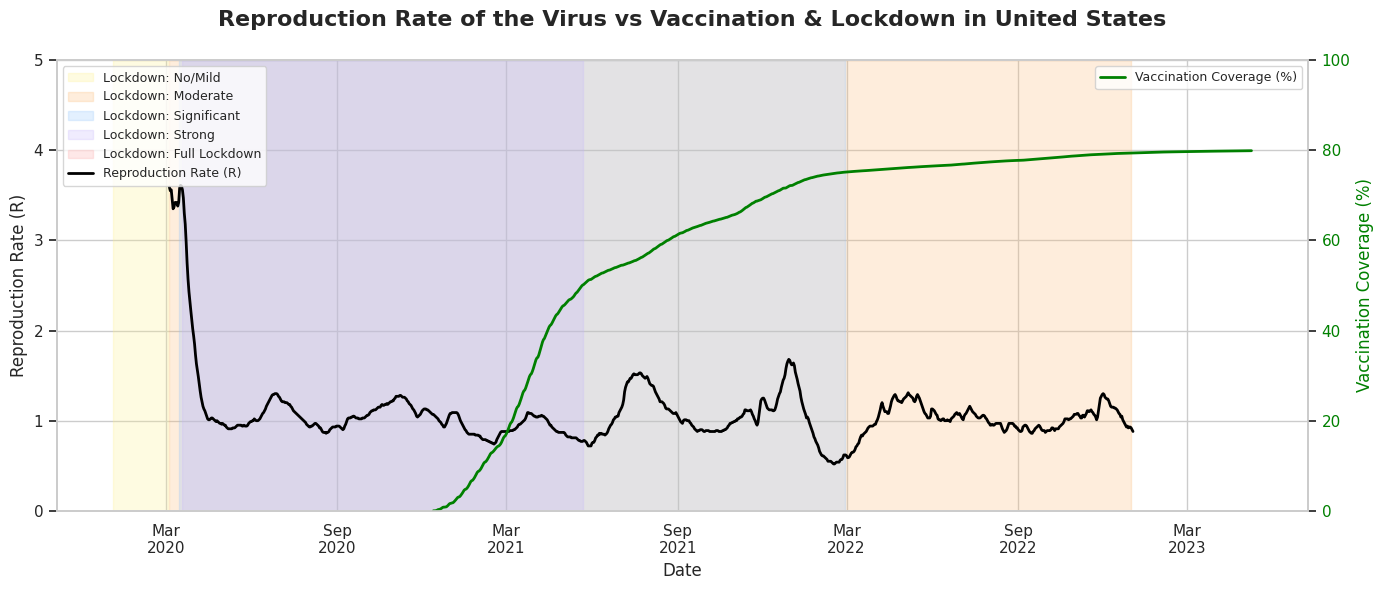

In [26]:
# Lockdown Tier Setup Function

def apply_lockdown_tiers(covid):
    tier_thresholds = {
        "No/Mild": (0, 20),
        "Moderate": (20, 40),
        "Significant": (40, 60),
        "Strong": (60, 80),
        "Full Lockdown": (80, 100)
    }

    tier_labels = list(tier_thresholds.keys())
    tier_bins = [0] + [v[1] for v in tier_thresholds.values()]

    covid['stringency_tier'] = pd.cut(
        covid['stringency_index'],
        bins=tier_bins,
        labels=tier_labels,
        include_lowest=True
    )

    tier_colors = {
        "No/Mild": "#fef08a",
        "Moderate": "#fdba74",
        "Significant": "#93c5fd",
        "Strong": "#c4b5fd",
        "Full Lockdown": "#fca5a5"
    }

    return covid, tier_colors

# Reproduction vs Vaccination Plot

def plot_reproduction_vs_vaccination(covid, country, tier_colors):
    sns.set(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(14, 6))

    for tier, color in tier_colors.items():
        mask = covid['stringency_tier'] == tier
        ax1.fill_between(
            covid.loc[mask, 'date'],
            0, 5,
            color=color,
            alpha=0.25,
            label=f"Lockdown: {tier}"
        )

    sns.lineplot(ax=ax1, data=covid, x='date', y='reproduction_rate',
                 label='Reproduction Rate (R)', color='black', linewidth=2)
    ax1.set_ylabel("Reproduction Rate (R)")
    ax1.set_ylim(0, 5)

    ax2 = ax1.twinx()
    sns.lineplot(ax=ax2, data=covid, x='date', y='vaccinated_pct',
                 label='Vaccination Coverage (%)', color='green', linewidth=2)
    ax2.set_ylabel("Vaccination Coverage (%)", color='green')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.grid(False)

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    fig.suptitle(f"Reproduction Rate of the Virus vs Vaccination & Lockdown in {country}", fontsize=16, weight='bold')
    ax1.set_xlabel("Date")
    ax1.legend(loc='upper left', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.show()

# Run Analysis

# Run this if you're inside a notebook
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()

# Select country
country = "United States"
country_df = analyzer.get_country_df(country)

# Add vaccination percentage
country_df['vaccinated_pct'] = (country_df['people_vaccinated'] / country_df['population']) * 100

# Apply lockdown tiers
country_df, tier_colors = apply_lockdown_tiers(country_df)

# Plot reproduction vs vaccination overlayed with lockdown
plot_reproduction_vs_vaccination(country_df, country, tier_colors)


**Case Fatality Rate (%) Among Top 10 Countries**

<ipython-input-27-40ef57c7f3e3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cfr_df, y='location', x='CFR (%)', palette='Reds_r')


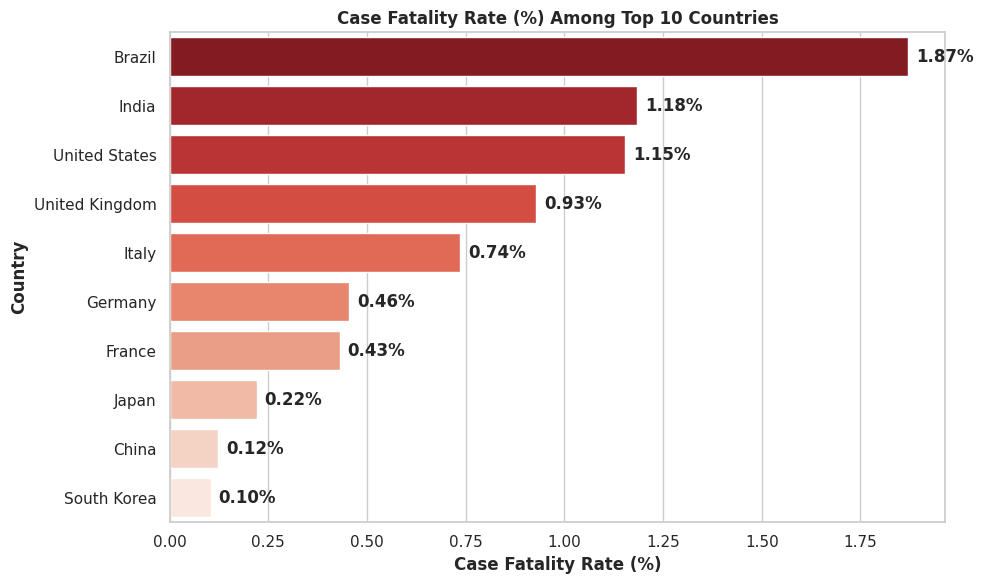

In [27]:
# Setup analyzer
analyzer = CovidTrendAnalyzer(df_cleaned)
analyzer.preprocess()

# Get most recent valid entries per country
recent = analyzer.get_latest_totals(['total_cases', 'total_deaths'])

# Get top 10 countries by total cases
top_countries = recent.groupby('location')['total_cases'].sum().nlargest(10).index.tolist()

# Calculate CFR
cfr_df = recent[recent['location'].isin(top_countries)].copy()
cfr_df['CFR (%)'] = (cfr_df['total_deaths'] / cfr_df['total_cases']) * 100
cfr_df = cfr_df.sort_values('CFR (%)', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=cfr_df, y='location', x='CFR (%)', palette='Reds_r')

for i, value in enumerate(cfr_df['CFR (%)']):
    plt.text(value + 0.02, i, f"{value:.2f}%", va='center', fontweight='bold')

plt.title("Case Fatality Rate (%) Among Top 10 Countries", fontweight='bold')
plt.xlabel("Case Fatality Rate (%)", fontweight='bold')
plt.ylabel("Country", fontweight='bold')
plt.tight_layout()
plt.show()




**Vaccination Rate vs. New COVID-19 Cases per Thousand**

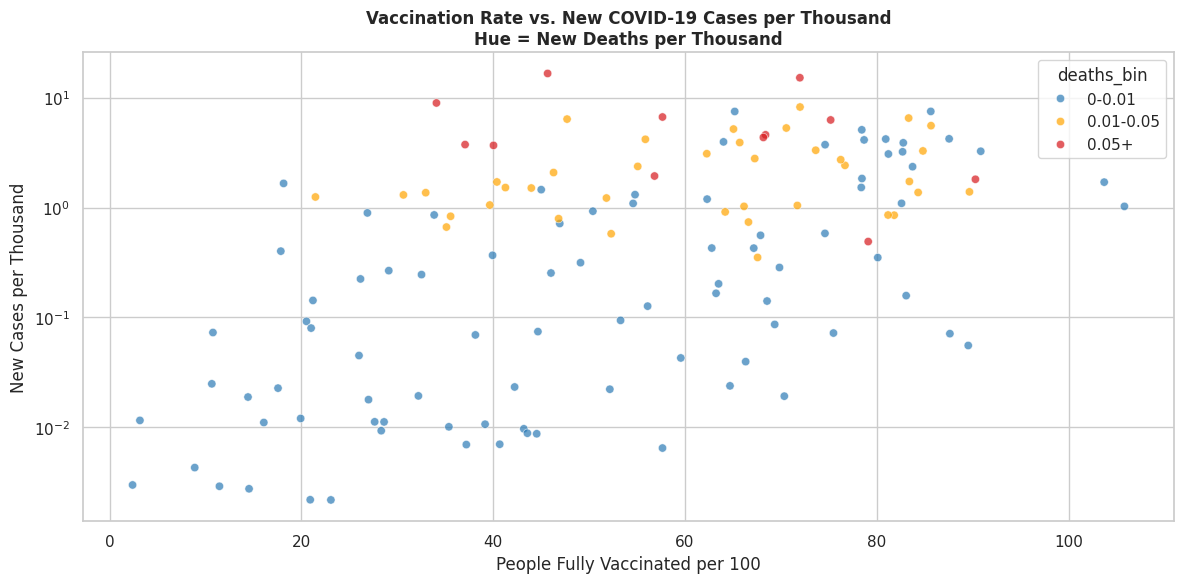

In [28]:
# Setup
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()

# Get processed per-capita dataframe
df_vax = analyzer.get_vaccination_case_death_df()

# Aggregate 1 row per country (max values)
plot_sample = (
    df_vax.groupby('location').agg({
        'people_fully_vaccinated_per_hundred': 'max',
        'new_cases_per_thousand': 'max',
        'new_deaths_per_thousand': 'max'
    }).reset_index()
)

# Define death bins for hue
bins = [0, 0.01, 0.05, float('inf')]
labels = ['0-0.01', '0.01-0.05', '0.05+']
plot_sample['deaths_bin'] = pd.cut(plot_sample['new_deaths_per_thousand'], bins=bins, labels=labels)

custom_palette = {
    '0-0.01': '#2c7bb6',
    '0.01-0.05': '#ffa500',
    '0.05+': '#d7191c'
}

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=plot_sample,
    x='people_fully_vaccinated_per_hundred',
    y='new_cases_per_thousand',
    hue='deaths_bin',
    palette=custom_palette,
    alpha=0.7
)

plt.title("Vaccination Rate vs. New COVID-19 Cases per Thousand\nHue = New Deaths per Thousand", fontweight='bold')
plt.xlabel("People Fully Vaccinated per 100")
plt.ylabel("New Cases per Thousand")
plt.yscale('log')
plt.tight_layout()
plt.show()


**Regional COVID-19 Impact Normalized by Continental Population**

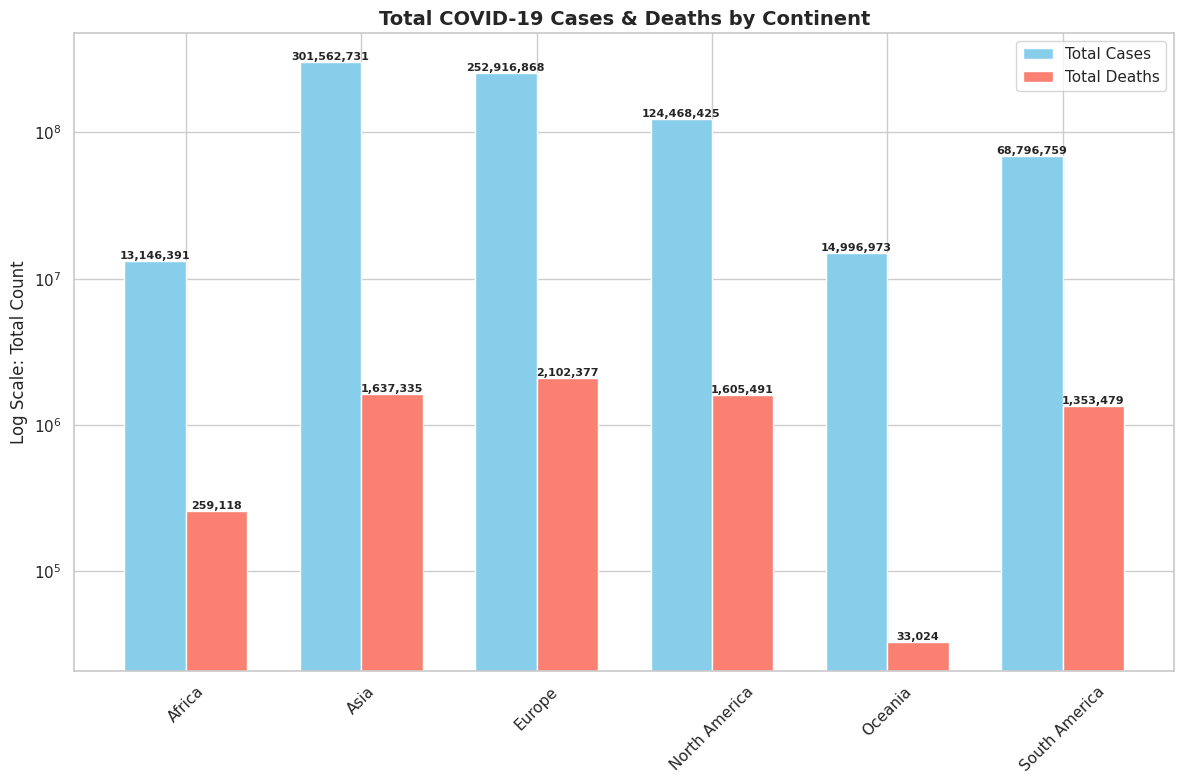

In [29]:
# Prepare data
analyzer = CovidTrendAnalyzer(covid)
analyzer.preprocess()
continent_totals = analyzer.get_continent_totals()

# Extract values
continents = continent_totals['continent']
cases = continent_totals['total_cases']
deaths = continent_totals['total_deaths']

# X-axis settings
x = np.arange(len(continents))
bar_width = 0.35

# Plot setup
plt.figure(figsize=(12, 8))
bars1 = plt.bar(x - bar_width/2, cases, width=bar_width, label='Total Cases', color='skyblue')
bars2 = plt.bar(x + bar_width/2, deaths, width=bar_width, label='Total Deaths', color='salmon')

# Log scale to visualize smaller bars
plt.yscale('log')

# Axis labels and ticks
plt.xticks(x, continents, rotation=45)
plt.ylabel("Log Scale: Total Count")
plt.title("Total COVID-19 Cases & Deaths by Continent", fontsize=14, weight='bold')
plt.legend()

# Add value labels above bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=8, fontweight ='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=8, fontweight ='bold')

plt.tight_layout()
plt.show()

**Days to Peak Cases: Top Peak Country in Each Continent**

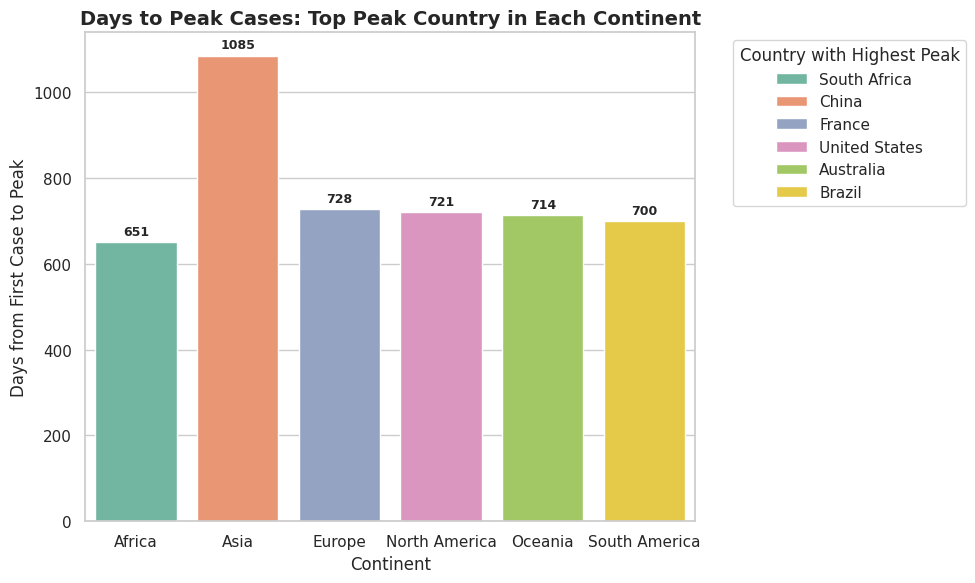

In [30]:
analyzer = CovidTrendAnalyzer(df_cleaned)
analyzer.preprocess()
peak_data = analyzer.get_days_to_peak_by_continent()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=peak_data, x='continent', y='days_to_peak', hue='location', dodge=False, palette='Set2')

for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3, fontweight = 'bold')

plt.title("Days to Peak Cases: Top Peak Country in Each Continent", fontsize=14, weight='bold')
plt.ylabel("Days from First Case to Peak")
plt.xlabel("Continent")
plt.legend(title="Country with Highest Peak", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**COVID-19: Population Density vs. New Cases per Million**

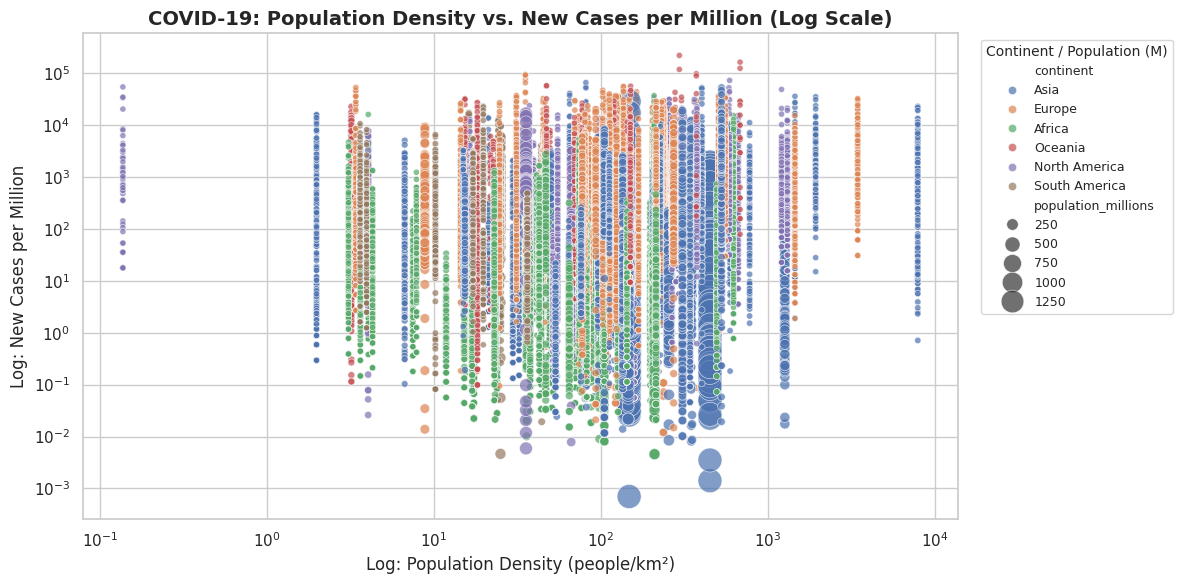

In [31]:
# Compute new cases per million
covid['new_cases_per_million'] = (covid['new_cases'] / covid['population']) * 1_000_000

# Drop rows with missing values
df_filtered = covid.dropna(subset=[
    'location', 'continent', 'population', 'population_density', 'new_cases_per_million'
]).copy()

# Filter extreme values
df_filtered = df_filtered[df_filtered['population_density'] < 8000]
df_filtered['population_millions'] = df_filtered['population'] / 1_000_000

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

scatter = sns.scatterplot(
    data=df_filtered,
    x='population_density',
    y='new_cases_per_million',
    hue='continent',
    size='population_millions',
    sizes=(20, 300),
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5
)

# Set log scales
plt.xscale('log')
plt.yscale('log')

# Labels & formatting
plt.title("COVID-19: Population Density vs. New Cases per Million (Log Scale)", fontweight='bold', fontsize=14)
plt.xlabel("Log: Population Density (people/km²)", fontsize=12)
plt.ylabel("Log: New Cases per Million", fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Continent / Population (M)', fontsize=9, title_fontsize=10)
plt.tight_layout()
plt.show()
